Load module

In [168]:
import requests as req
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Sequence Labeling with POS tagging HMM

In [169]:
class SequenceLabeling:
  def __init__(self):
    # url_based menunjukkan url dataset
    self.url_based = 'https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/bapos_pos-idn/'

  # memperoleh response dari API github
  def getResponseText(self, url):
    response = req.get(url)

    if response.status_code == 200:
      return {
          'text': response.text,
          'status': 200
      }
    else:
      return {
          'text': '',
          'status': response.status_code
      }

  # memproses response dan mengubahnya ke dalam bentuk array 1D yg nanti digunakan untuk membaca ke dalam dataframe
  def response_preprocess(self):
    train = self.getResponseText(self.url_based + 'train_preprocess.txt')
    train = train['text'].split('\n') if train['status'] == 200 else None

    test = self.getResponseText(self.url_based + 'test_preprocess.txt')
    test = test['text'].split('\n') if test['status'] == 200 else None

    validation = self.getResponseText(self.url_based + 'valid_preprocess.txt')
    validation = validation['text'].split('\n') if validation['status'] == 200 else None

    train_code = np.array([tr.split('\t') for tr in train if tr])[:, 1]
    train_text = np.array([tr.split('\t') for tr in train if tr])[:, 0]

    test_code = np.array([ts.split('\t') for ts in test if ts])[:, 1]
    test_text = np.array([ts.split('\t') for ts in test if ts])[:, 0]

    val_code = np.array([val.split('\t') for val in validation if val])[:, 1]
    val_text = np.array([val.split('\t') for val in validation if val])[:, 0]

    return {
        'train_code': train_code,
        'train_text': train_text,
        'test_code': test_code,
        'test_text': test_text,
        'val_code': val_code,
        'val_text': val_text
    }

  # fungi membaca pandas general
  def pandas_reading(self, text, code):
    df = pd.DataFrame({
        'word': text,
        'tags': code
    })

    return df

  # fungsi pembaca dataframe dan mengembalikan nilai training, testing dan validation
  def myDataframe(self, **data):
    training = self.pandas_reading(data['train_text'], data['train_code'])
    testing = self.pandas_reading(data['test_text'], data['test_code'])
    valid = self.pandas_reading(data['val_text'], data['val_code'])

    return training, testing, valid

  # fungsi menghitung transition, emission, unique word dan tags, dan jumlah dari unique
  def init_of_wordtags(self, df):
    # Mengekstraks unique words dan tags
    words, tags = df['word'].values, df['tags'].values
    unique_words = list(set(words))
    unique_tags = list(set(tags))
    unique_words.append('<UNK>')

    # menentukan jumlah unique dari word dan tags
    self.num_tags = len(unique_tags)
    self.num_words = len(unique_words)

    # Membuat index dari word dan tag setelah mencari unique nilai outputnya object[word/tag] = index
    word_to_index = {word: i for i, word in enumerate(unique_words)}
    tag_to_index = {tag: i for i, tag in enumerate(unique_tags)}

    # melakukan random data 2 dimensi berukuran num_tags X num_tags
    transition_matrix = np.random.rand(self.num_tags, self.num_tags) #inisialiasi kemungkinan berpindah
    emission_matrix = np.random.rand(self.num_tags, self.num_words) #inisialisasi kemungkinan munculnya simbol

    # normalization supaya satu baris berjumlah 1
    transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)
    emission_matrix /= np.sum(emission_matrix, axis=1, keepdims=True)

    return [word_to_index, tag_to_index, unique_tags, unique_words, transition_matrix, emission_matrix]

  # Normalisasi transisi dan emisi metrik, axis=1 is column and keepdims adalah menjaga dimensi
  # p(x) = n + 1 / N + k
  # n = jumlah kemunculan kejadian dalam dataset, N = jumlah total kemungkinan kejadian, k = jumlah penambahan (panjang data)
  def smoothing_add_one(self, probabilities):
    smoothing_prob = np.zeros_like(probabilities)

    # hitung total observ
    total_count = np.sum(probabilities)

    # Add-1 smoothing formula
    num_obs = probabilities.shape[0]
    for i in range(num_obs):
      smoothing_prob[i] = (probabilities[i] + 1) / (total_count + num_obs)

    return smoothing_prob

  # fungsi forward algorithm untuk menghitung probabilitas semua kemungkinan dari observasi/sequence
  def algoritma_forward(self, input_sequence, emission_matrix, transition_matrix):
      # definisi alpha variable untuk bernilai 0 dalam dimensi num_tags X len(input_sequence)
      alpha = np.zeros((self.num_tags, len(input_sequence)))

      # t ke n
      for t in range(len(input_sequence)):
          for j in range(self.num_tags):
              if t == 0:
                  # alpha index baris j kolom t menjadi emision baris j dan kolom sequence ke t
                  emission_prob = emission_matrix[j, input_sequence[t]]

                  alpha[j, t] = emission_prob
              else:
                  # transition dan emission prob
                  transition_prob = transition_matrix[:, j]
                  zero_indices = np.where(transition_prob == 0)[0]
                  if zero_indices.size > 0:
                    # smoothing progress
                    transition_prob = self.smoothing_add_one(transition_prob)

                  emission_prob = emission_matrix[j, input_sequence[t]]

                  # alpha index baris j kolom t menjadi nilai (transition index pada setiap baris pada kolom j) * (emision pada index baris j pada kolom kolom sequence ke t)
                  alpha[j, t] = emission_prob * np.sum(alpha[:, t-1] * transition_prob)

      return alpha

  # fungsi algoritma viterbi untuk melihat urutan tersembunyi dari observasi setiap keadaan, fungsi ini mengembalikan nilai yg dapat di decode
  def algoritma_viterbi(self, input_sequence, emission_matrix, transition_matrix):
      delta = np.zeros((self.num_tags, len(input_sequence)))
      psi = np.zeros((self.num_tags, len(input_sequence)), dtype=int)

      for t in range(len(input_sequence)):
          for j in range(self.num_tags):
              if t == 0:
                  emission_prob = emission_matrix[j, input_sequence[t]]

                  delta[j, t] = emission_prob
              else:
                  transition_prob = transition_matrix[:, j]
                  zero_indices = np.where(transition_prob == 0)[0]
                  if zero_indices.size > 0:
                    # smoothing progress
                    transition_prob = self.smoothing_add_one(transition_prob)

                  emission_prob = emission_matrix[j, input_sequence[t]]

                  # mencari maximum dari delta dengan transition prob smoothing
                  # formula halaman 13 12_viterbi.pdf
                  max_probability = np.max(delta[:, t-1] * transition_prob)
                  delta[j, t] = emission_prob * max_probability
                  psi[j, t] = np.argmax(delta[:, t-1] * transition_prob)

      # backtrack untuk menemukan urutan keadaan yg paling mungkin
      best_path = [np.argmax(delta[:, -1])]
      for t in range(len(input_sequence) - 1, 0, -1):
          best_path.insert(0, psi[best_path[0], t])
      return best_path

In [170]:
sequence_label = SequenceLabeling()

response = sequence_label.response_preprocess()

train, test, valid = sequence_label.myDataframe(
    train_text=response['train_text'],
    train_code=response['train_code'],
    test_code=response['test_code'],
    test_text=response['test_text'],
    val_text=response['val_text'],
    val_code=response['val_code']
)

word_to_index, tag_to_index, unique_tags, unique_words, transition_matrix, emission_matrix = sequence_label.init_of_wordtags(train)

input_sequence = []

for word in test['word'].values:
  try:
    input_sequence.append(word_to_index[word])
  except KeyError:
    input_sequence.append(word_to_index['<UNK>'])

my_forward_algorithm = sequence_label.algoritma_forward(input_sequence, emission_matrix, transition_matrix)

my_viterbi_algorithm = sequence_label.algoritma_viterbi(input_sequence, emission_matrix, transition_matrix)

print('Total probabilitas dari kemungkinan observasi: ', my_forward_algorithm)
print('Urutan tersembunyi yg paling mungkin: ', my_viterbi_algorithm)

# Decode input_sequence dari model
decoded_tags = [unique_tags[index] for index in my_viterbi_algorithm]
print('Hasil decode viterbi:', decoded_tags)

Total probabilitas dari kemungkinan observasi:  [[1.23722273e-04 3.67223746e-10 3.53542963e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.19187245e-04 6.37544321e-09 4.88335106e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.76324156e-06 5.62136753e-09 6.06405901e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.16634702e-04 3.24285219e-09 1.89880806e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.23691840e-05 1.05422874e-09 2.50180471e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.26420311e-04 4.18632743e-09 2.90685553e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Urutan tersembunyi yg paling mungkin:  [20, 10, 28, 4, 23, 6, 10, 34, 30, 13, 17, 4, 20, 32, 26, 29, 22, 23, 35, 15, 33, 22, 23, 6, 16, 4, 7, 10, 28, 4, 1, 20, 26, 22, 25, 16, 4, 23, 18, 33, 22, 28, 16, 4, 20, 10, 12, 10, 28, 13, 17, 15, 17, 4, 22, 23, 6, 10, 9, 34, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [171]:
df = pd.DataFrame(
    {
        'words': test['word'].values,
        'tags_uji': test['tags'].values,
        'tags_pred': decoded_tags
    }
)
df.head(20)

,words,tags_uji,tags_pred
0,Pada,B-IN,B-RB
1,2005,B-CD,I-OD
2,",",B-Z,I-RB
3,tembakan,B-NN,I-CC
4,musuh,B-NN,I-JJ
5,dari,B-IN,B-PR
6,darat,B-NN,I-OD
7,ke,B-IN,B-UH
8,udara,B-NN,B-NN
9,menjatuhkan,B-VB,B-NEG


In [172]:
np.sum(my_forward_algorithm, axis=1)

array([1.23722640e-04, 1.19193621e-04, 1.76886353e-06, 1.19108738e-04,
       1.06008198e-04, 1.28701416e-04, 1.01638559e-04, 3.47435385e-05,
       8.41334768e-06, 5.88108070e-05, 3.71249393e-05, 2.86331481e-05,
       1.16348702e-05, 1.11660936e-04, 9.12142196e-05, 9.85753982e-05,
       8.72581182e-05, 7.19394150e-05, 1.13553196e-04, 2.73544932e-05,
       1.11112439e-04, 1.24982189e-04, 1.04913141e-04, 1.17189874e-04,
       7.74984845e-05, 7.96189371e-05, 4.49478371e-05, 1.69554989e-05,
       8.75998819e-05, 8.25999608e-05, 1.11005742e-04, 1.93688301e-05,
       7.15833114e-05, 1.50755651e-05, 7.96965962e-05, 2.29596389e-05,
       4.70867148e-05, 1.16637945e-04, 7.23702385e-05, 1.26424497e-04])

Sequence Labeling with RNN and Bi-LSTM

In [173]:
# Bi-Lstm and RNN
class SequenceLabelingWithNN(SequenceLabeling):
  def __init__(self):
    super().__init__()
    self.hidden_dim_rnn = 64     # Dimensi hidden layer RNN
    self.hidden_dim_lstm = 64

  def data_preparation(self):
    data = self.response_preprocess()

    train, test, valid = self.myDataframe(
        train_text=data['train_text'],
        train_code=data['train_code'],
        test_code=data['test_code'],
        test_text=data['test_text'],
        val_text=data['val_text'],
        val_code=data['val_code']
    )

    return train, test, valid

  def encode_label(self, labels, is_train=False):
    label_encoder = LabelEncoder()

    # Melakukan encoding label kelas
    encoded_labels = label_encoder.fit_transform(labels)

    if is_train:
      print('train', len(label_encoder.classes_))
      self.encoder_train = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    else:
      print('val', len(label_encoder.classes_))
      self.encoder_valid = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

    return encoded_labels

  def save_word_tags(self, df):
    words, tags = df['word'].values, df['tags'].values
    unique_words = list(set(words))
    unique_tags = list(set(tags))
    self.vocab_size = len(unique_words)
    self.num_classes = len(unique_tags)
    self.embedding_dim = 32

  def default_callback(self):
    checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
        filepath='sample_data/',
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    return checkpoint_callback_loss
  def callbacks(self):
    checkpoint_path_loss = "drive/My Drive/ML-progress/NLP-UTS/val_loss.h5"
    checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_loss,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    checkpoint_path_acc = "drive/My Drive/ML-progress/NLP-UTS/val_acc.h5"
    checkpoint_callback_acc = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_acc,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    return [checkpoint_callback_loss, checkpoint_callback_acc]

  def text_preprocessing(self, train, val):
    # Tokenisasi kata-kata
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train['word'])

    # kata menjadi urutan angka
    train_sequence = tokenizer.texts_to_sequences(train['word'])
    val_sequence = tokenizer.texts_to_sequences(val['word'])

    # padding menyetarakan panjang
    max_all_seq = max(len(seq) for seq in train_sequence)
    train_padded = pad_sequences(train_sequence, maxlen=max_all_seq, padding='post')
    val_padded = pad_sequences(val_sequence, maxlen=max_all_seq, padding='post')

    return tokenizer, train_padded, val_padded, max_all_seq

  def training_phase(self, train, valid):
    self.save_word_tags(train)

    tokenizer, train_padded, val_padded, max_all_seq = self.text_preprocessing(train, valid)

    train_label = self.encode_label(train['tags'].values, True)
    val_label = self.encode_label(valid['tags'].values, False)

    callbacks = self.callbacks()

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_all_seq),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.SimpleRNN(64, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
        tf.keras.layers.Dense(len(set(train_label)), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Melatih model dengan data latihan
    history = model.fit(train_padded, train_label, epochs=20, batch_size=30, validation_data=(val_padded, val_label), callbacks=callbacks)

    return model, history

In [174]:
neural_network_sequencing = SequenceLabelingWithNN()

In [175]:
train, test, valid = neural_network_sequencing.data_preparation()

In [176]:
callbacks = neural_network_sequencing.default_callback()

model, history = neural_network_sequencing.training_phase(train, valid)
model

train 40
val 37
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 3, 64)             735040    
                                                                 
 lstm_37 (LSTM)              (None, 3, 64)             33024     
                                                                 
 simple_rnn_37 (SimpleRNN)   (None, 3, 64)             8256      
                                                                 
 flatten_17 (Flatten)        (None, 192)               0         
                                                                 
 dense_50 (Dense)            (None, 64)                12352     
                                                                 
 dense_51 (Dense)            (None, 40)                2600      
                                                                 
Total params: 791272 (3.02 MB)
Traina

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7149/7149 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.9144
Epoch 2: val_loss did not improve from 5.10051

Epoch 2: val_accuracy improved from 0.61087 to 0.61346, saving model to drive/My Drive/ML-progress/NLP-UTS/val_acc.h5
7149/7149 [==============================] - 141s 20ms/step - loss: 0.2865 - accuracy: 0.9144 - val_loss: 6.1641 - val_accuracy: 0.6135
Epoch 3/20
7148/7149 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9199
Epoch 3: val_loss did not improve from 5.10051

Epoch 3: val_accuracy improved from 0.61346 to 0.61462, saving model to drive/My Drive/ML-progress/NLP-UTS/val_acc.h5
7149/7149 [==============================] - 138s 19ms/step - loss: 0.2590 - accuracy: 0.9199 - val_loss: 6.9405 - val_accuracy: 0.6146
Epoch 4/20
7149/7149 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9213
Epoch 4: val_loss did not improve from 5.10051

Epoch 4: val_accuracy improved from 0.61462 to 0.61741, saving mo

In [177]:
def predict_sequence_labels(model, tokenizer, input_sequence):
    # Tokenize the input sequence
    input_sequence = tokenizer.texts_to_sequences(input_sequence)
    input_sequence = pad_sequences(input_sequence, maxlen=max_all_seq, padding='post')

    # Predict labels for the input sequence
    predicted_labels = model.predict(input_sequence)

    return predicted_labels

tokenizer, _, _, max_all_seq = neural_network_sequencing.text_preprocessing(train, valid)
input_sequence = test['word'].values
predicted_labels = predict_sequence_labels(model, tokenizer, input_sequence)
print(predicted_labels)


835/835 [==============================] - 3s 3ms/step
[[0.00000000e+00 1.54795501e-08 0.00000000e+00 ... 0.00000000e+00
  2.42118090e-27 1.75373498e-23]
 [5.71440356e-13 9.80727851e-01 7.65192007e-11 ... 3.96018442e-17
  2.32168105e-07 9.36133327e-19]
 [1.40807550e-27 2.98855768e-04 4.26360553e-19 ... 3.17282173e-11
  7.17293180e-04 1.62788446e-03]
 ...
 [0.00000000e+00 1.63861522e-10 0.00000000e+00 ... 0.00000000e+00
  3.11911285e-15 6.92926345e-18]
 [4.08061510e-07 2.04734430e-02 5.05164473e-19 ... 4.08535240e-17
  2.41322760e-12 1.21264014e-11]
 [1.40807579e-27 2.98855826e-04 4.26360605e-19 ... 3.17282242e-11
  7.17293296e-04 1.62788469e-03]]


In [181]:
# neural_network_sequencing.encoder_train
model.save('drive/My Drive/ML-progress/NLP-UTS/nlp_model.h5')

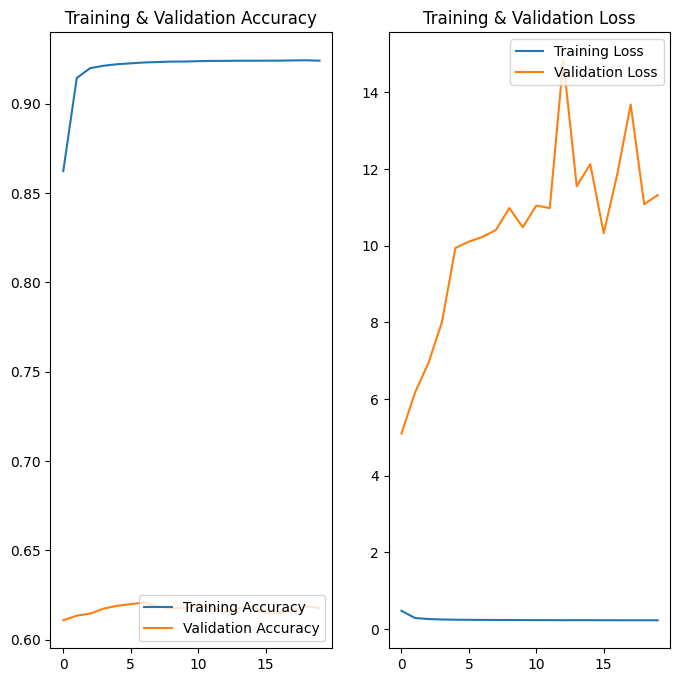

In [184]:
def showAllValueOfHistory(history, epochs_range):
    epochs_range = range(epochs_range)
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')
    return plt.show()

showAllValueOfHistory(history, 20)

In [185]:
# resource
# https://www.geeksforgeeks.org/rnn-for-sequence-labeling/
# https://towardsdatascience.com/sequence-to-sequence-labeling-with-recurrent-neural-networks-5405716a2ffa